<a href="https://colab.research.google.com/github/sgupt1802/MyTorchTuts/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Convert MNIST Image files into tensors of 4 dimensions.


In [4]:
### We will transform the images data because the input will be a two dimensional image but we need a 4 dimensions because we want to store the (number of images, the height, the width and the color)
transform=transforms.ToTensor()


In [5]:
# Train_data
train_data=datasets.MNIST(root='/cnn_data',train=True,download=True,transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 35129723.20it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 1202590.06it/s]

Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 9471216.00it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 11387046.48it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [6]:
len(train_data)

60000

In [7]:
#Test data
test_data=datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10,shuffle=False)

In [11]:
## Defining the Model
conv1=nn.Conv2d(1,6,3,1)
conv2=nn.Conv2d(6,18,3,1)

In [12]:
#Taking the first MNIST Record
for i,(X_Train,y_train) in enumerate(train_data):
  break

In [13]:
X_Train.shape

torch.Size([1, 28, 28])

In [14]:
x=X_Train.view(1,1,28,28)

In [15]:
## First convolution
x=F.relu(conv1(x))

In [16]:
x.shape

torch.Size([1, 6, 26, 26])

In [17]:
## pass through the pooling layer
x=F.max_pool2d(x,2,2)   # kernel of 2 and the stride of 2

In [18]:
x.shape    ## 26/2=13

torch.Size([1, 6, 13, 13])

In [19]:
## second convolution
x=F.relu(conv2(x))

In [20]:
x.shape

torch.Size([1, 18, 11, 11])

In [21]:
x=F.max_pool2d(x,2,2)

In [22]:
x.shape

torch.Size([1, 18, 5, 5])

### Building the CNN Model

In [30]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3,1)
    self.conv2=nn.Conv2d(6,16,3,1)

    ##fully connected layer
    self.fc1=nn.Linear(5*5*16,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self,X):
    ## first pass
    X=F.relu(self.conv1(X))
    X=F.max_pool2d(X,2,2)  ##2*2 kernel and stride

    ## second pass
    X=F.relu(self.conv2(X))
    X=F.max_pool2d(X,2,2)  ##2*2 kernel and stride

    ##Review to flatten this out
    X=X.view(-1,16*5*5)                       ## -1 so that we can vary the batch size

    ## Fully connected layers
    X=F.relu(self.fc1(X))
    X=F.relu(self.fc2(X))
    X=self.fc3(X)

    return F.log_softmax(X,dim=1)

In [31]:
##Create an instance of model
torch.manual_seed(42)
model=ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [33]:
import time
start_time=time.time()

## creating variables to track things
epochs=5
train_losses=[]
test_losses=[]
train_correct_list=[]
test_correct_list=[]

## epoch loop
for i in range(epochs):
  train_correct=0
  test_correct=0


  #Train
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred=model(X_train)
    loss=criterion(y_pred,y_train)


    predicted=torch.max(y_pred.data,1)[1]
    batch_correct=(predicted==y_train).sum()
    train_correct+= batch_correct

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    ## Print out some results
    if b%600==0:
      print(f'Epoch: {i} Batch: {b} Loss:{loss.item()}')

  train_losses.append(loss)
  train_correct_list.append(train_correct)


  ### test
  with torch.no_grad():              ## not to update the w and b in testing.
   for b,(X_test,y_test) in enumerate(test_loader):
    y_val=model(X_test)
    predicted=torch.max(y_val.data,1)[1]
    test_correct+=(predicted==y_test).sum()


  loss=criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct_list.append(test_correct)




current_time=time.time()
total_time=current_time-start_time
print(f'Training took: {total_time/60} minutes.')


Epoch: 0 Batch: 600 Loss:0.040556274354457855
Epoch: 0 Batch: 1200 Loss:0.08253474533557892
Epoch: 0 Batch: 1800 Loss:0.3647049069404602
Epoch: 0 Batch: 2400 Loss:0.018250251188874245
Epoch: 0 Batch: 3000 Loss:0.008067040704190731
Epoch: 0 Batch: 3600 Loss:0.001166942878626287
Epoch: 0 Batch: 4200 Loss:0.5255253911018372
Epoch: 0 Batch: 4800 Loss:0.03260819613933563
Epoch: 0 Batch: 5400 Loss:0.007468158844858408
Epoch: 0 Batch: 6000 Loss:0.03889675810933113
Epoch: 1 Batch: 600 Loss:0.032828204333782196
Epoch: 1 Batch: 1200 Loss:0.04554177075624466
Epoch: 1 Batch: 1800 Loss:0.005784796085208654
Epoch: 1 Batch: 2400 Loss:0.02235613949596882
Epoch: 1 Batch: 3000 Loss:0.21643038094043732
Epoch: 1 Batch: 3600 Loss:0.00501451687887311
Epoch: 1 Batch: 4200 Loss:0.00045869071618653834
Epoch: 1 Batch: 4800 Loss:0.0019295118981972337
Epoch: 1 Batch: 5400 Loss:0.0008596166153438389
Epoch: 1 Batch: 6000 Loss:0.08304359018802643
Epoch: 2 Batch: 600 Loss:0.0006373372743837535
Epoch: 2 Batch: 1200 Lo

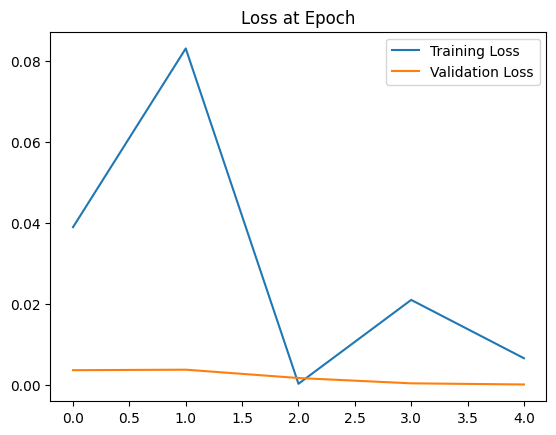

In [34]:
## train_losses=train_losses.detach().numpy()
train_losses=[tl.item() for tl in train_losses]              ## for taking numpy out of tensors
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Validation Loss')
plt.title('Loss at Epoch')
plt.legend()

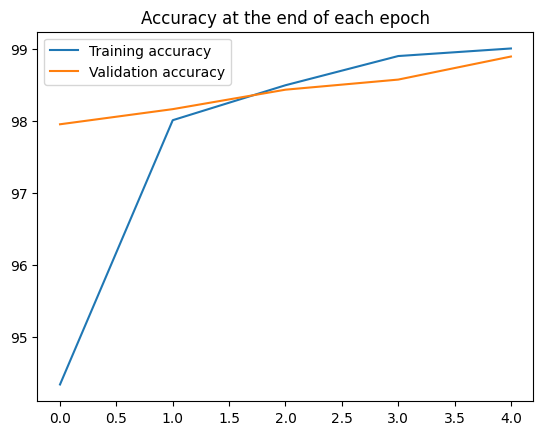

In [35]:
## accuracy at the end of each graph
plt.plot([t/600 for t in train_correct_list],label='Training accuracy')
plt.plot([t/100 for t in test_correct_list],label='Validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [36]:
test_load_everything=DataLoader(test_data,batch_size=10000,shuffle=False)

In [37]:
with torch.no_grad():
  correct=0
  for X_test,y_test in test_load_everything:
    y_val=model(X_test)
    predicted=torch.max(y_val,1)[1]
    correct+=(predicted==y_test).sum()

In [40]:
correct.item()/len(test_data)*100

98.89

In [44]:
test_data[3484]     ## tensor with image in it and label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [45]:
test_data[3484][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [46]:
test_data[3484][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

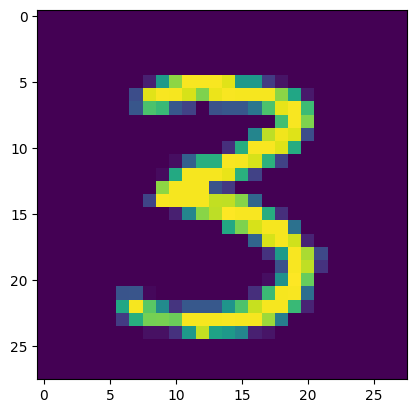

In [47]:
plt.imshow(test_data[3484][0].reshape(28,28))

In [48]:
### Pass the image through our model
model.eval()
with torch.no_grad():
  new_prediction=model(test_data[3484][0].view(1,1,28,28))          ## batch size of 1, 1 color channel,28*28 img

In [49]:
new_prediction

tensor([[-51.3167, -36.9420, -35.5809,   0.0000, -51.5703, -28.9050, -52.5823,
         -39.6501, -27.9734, -34.2891]])

In [50]:
new_prediction.argmax()

tensor(3)

In [67]:
### predicting any downloaded image after applying transformations
from PIL import Image
import torch
import torchvision.transforms as transforms

# Resize the image to 28x28 and convert to grayscale
image = Image.open("download4.png").convert("L")
image = image.resize((28, 28))

transform = transforms.ToTensor()
image_tensor = transform(image)

model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))  # Add batch dimension

predicted_class = torch.argmax(output).item()
print("Predicted class:", predicted_class)


Predicted class: 6
